# Quadrupolar Coupling Demo PULSEE

# Imports

In [1]:
import numpy as np
import pandas as pd
from pulsee.operators import * 
from pulsee.simulation import *
import qutip as qt
import matplotlib.pyplot as plt

# Parameters

In [2]:
Ix, Iy, Iz = qt.spin_J_set(3 / 2)

In [3]:
qn = 3 / 2
gr = 1
B0 = 1
e2qQ = 0.1

B1 = 1e-1
    
spin_par = {'quantum number' : qn,
			'gamma/2pi' : gr}

zeem_par = {'field magnitude' : B0,
			'theta_z' : 0,
			'phi_z' : 0}

In [4]:
etas = np.linspace(0, 1, 2)

# Simulation
Define simulation code which we will run with different solvers:

In [5]:
h_unperturbed=None
spin=None

In [6]:
def simulate(solver):
    global h_unperturbed
    global spin
    # Fourier transforms for each eta
    fts = []

    for eta in etas:
        quad_par = {'coupling constant' : e2qQ,
                    'asymmetry parameter' : eta,
                    'alpha_q' : 0.,
                    'beta_q' : 0.,
                    'gamma_q' : 0.,
                    'order' : 0}


        
        mode = pd.DataFrame([( B0 * gr, B1, 0., np.pi/2, 0)], 
                            columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'], )

        spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par,
                                            zeem_par=zeem_par, initial_state='canonical', temperature=1e-1)
        
        print('Initial_state')
        fig = plot_real_part_density_matrix(dm_initial)
#         print(np.round(dm_initial.full(), 3))
        opts = Options(atol=1e-12, rtol=1e-16, rhs_reuse=False, nsteps=20000)
        dm_evolved = evolve(spin, h_unperturbed, dm_initial, solver=solver, \
                            mode=mode, pulse_time = 2 / (4 * 3 * gr * B1), \
                            picture='IP', n_points=60, opts=opts, order=1)
        
        print('Evolved_state')
        fig = plot_real_part_density_matrix(dm_evolved)
#         print(np.round(dm_evolved.full(), 3))
        t, FID = FID_signal(spin, h_unperturbed, dm_evolved, acquisition_time=800, \
                            T2=100, reference_frequency=0, n_points=5)

        f, ft = fourier_transform_signal(FID, t, padding=2)
        fts.append([eta, f, ft, t, FID])
    return fts

In [7]:
h_unperturbed=None
spin=None

# Plots

Run simulations with Magnus solve

Initial_state


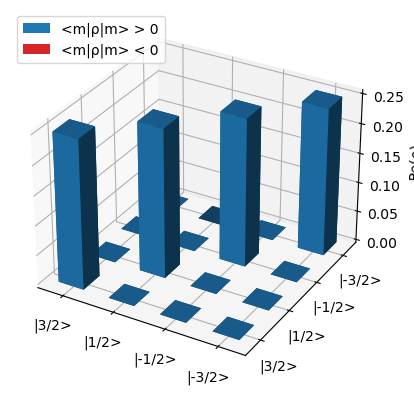

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 535.70it/s]

Evolved_state


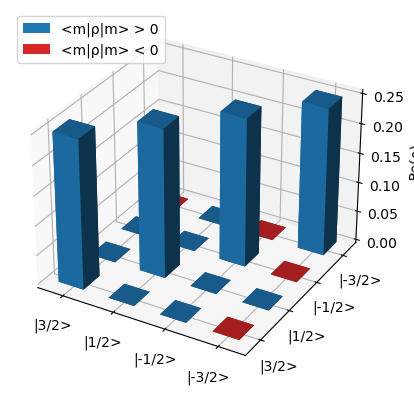

Initial_state


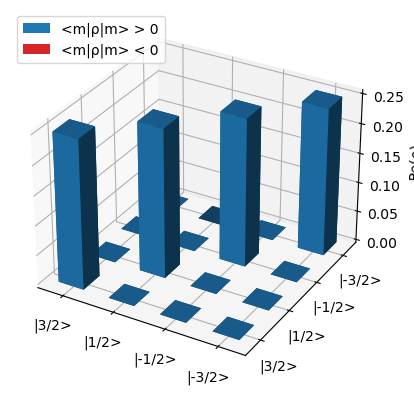

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 582.51it/s]

Evolved_state


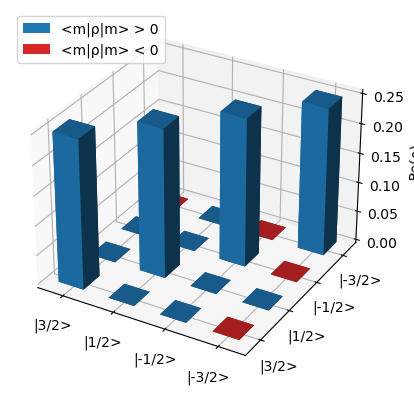

In [8]:
fts_magnus = simulate('magnus')

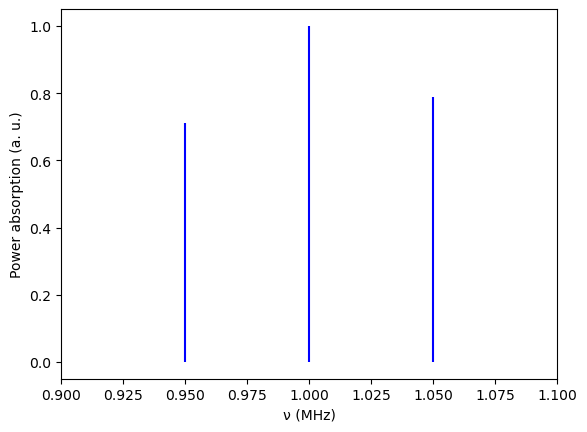

In [9]:
# Theoretically calculated where the expected transitions should be using the Fermi golden rule
f, p = power_absorption_spectrum(spin, h_unperturbed, normalized=True)
_ = plot_power_absorption_spectrum(f, p, xlim=[.9, 1.1])

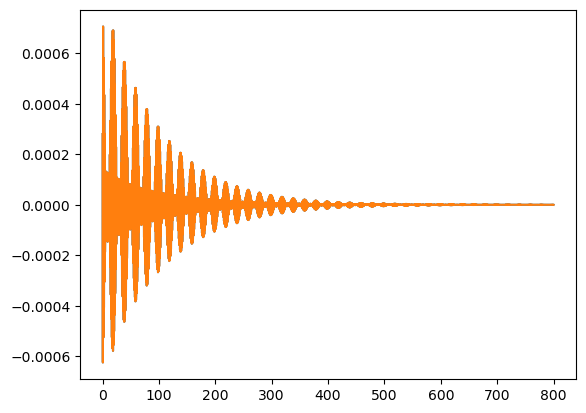

In [10]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_magnus: 
	plt.plot(t, np.real(fid))

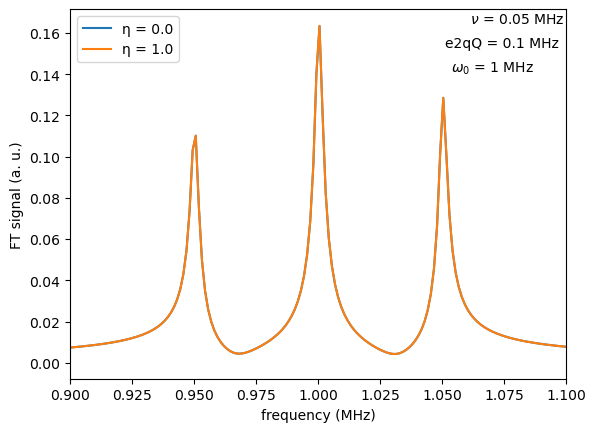

In [11]:
fig, ax = plt.subplots()
# for eta, f, ft, t, fid in fts_magnus:
#     plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))
for eta, f, ft, t, fid in fts_magnus:
    plt.plot(f, np.abs(ft), label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.71, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.figtext(.75, .85, r'$\nu$ = ' + str(np.round(e2qQ/2, 3)) + ' MHz')
plt.figtext(.72, .75, r'$\omega_0$ = ' + str(np.round(gr * B0, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(.9, 1.1)
plt.show()

Plot & solve mesolve solution QuTiP's [master equation solver](https://qutip.org/docs/latest/modules/qutip/mesolve.html#mesolve)::

Initial_state


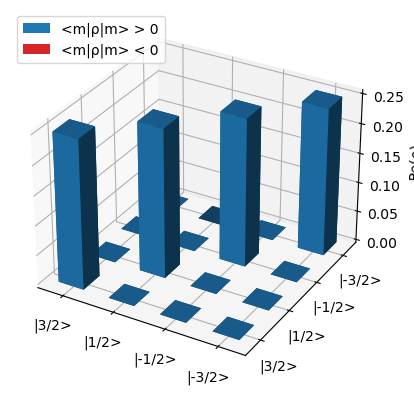

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
70.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.01s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s
Evolved_state


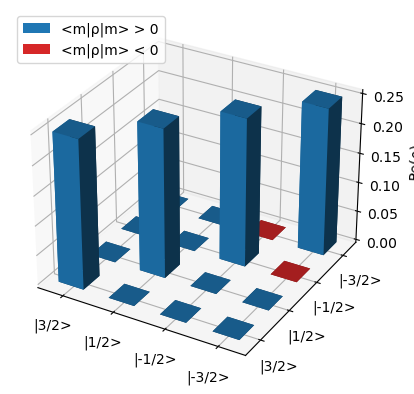

Initial_state


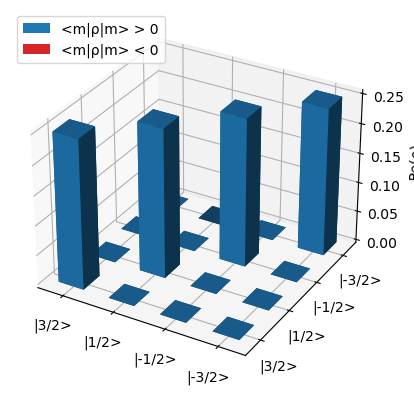

10.0%. Run time:   0.00s. Est. time left: 00:00:00:00
20.0%. Run time:   0.00s. Est. time left: 00:00:00:00
30.0%. Run time:   0.00s. Est. time left: 00:00:00:00
40.0%. Run time:   0.00s. Est. time left: 00:00:00:00
50.0%. Run time:   0.00s. Est. time left: 00:00:00:00
60.0%. Run time:   0.01s. Est. time left: 00:00:00:00
70.0%. Run time:   0.01s. Est. time left: 00:00:00:00
80.0%. Run time:   0.01s. Est. time left: 00:00:00:00
90.0%. Run time:   0.01s. Est. time left: 00:00:00:00
Total run time:   0.01s
Evolved_state


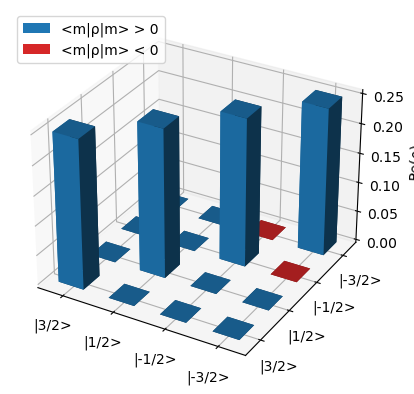

In [12]:
fts_mesolve = simulate('mesolve')

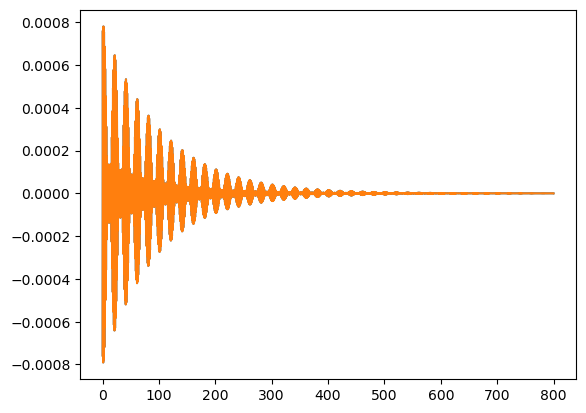

In [13]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_mesolve: 
	plt.plot(t, np.imag(fid))

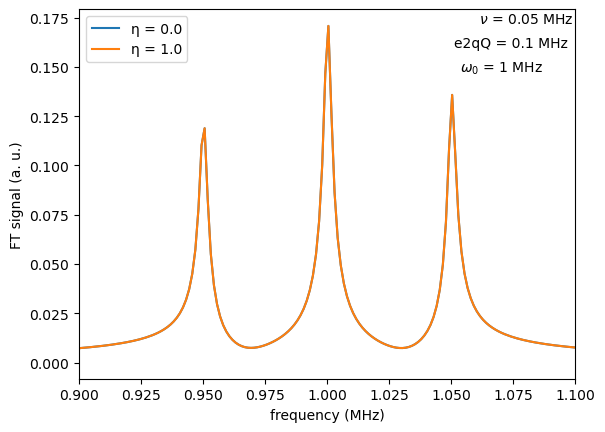

In [14]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_mesolve:
    plt.plot(f, np.abs(ft), label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.71, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.figtext(.75, .85, r'$\nu$ = ' + str(np.round(e2qQ/2, 3)) + ' MHz')
plt.figtext(.72, .75, r'$\omega_0$ = ' + str(np.round(gr * B0, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(.9, 1.1)
plt.show()

One must experiment with the pulse duration to find the exact $\pi/2$ pulse. This is hard because of the presence of the Zeeman term in the Hamiltonian. The spins are rotating during the evolution of the pulse with respect to the applied field. This is why the peaks for the $\eta = 0$ case are not exacly symmetric. 

Simulate with exact diagonalization approach:

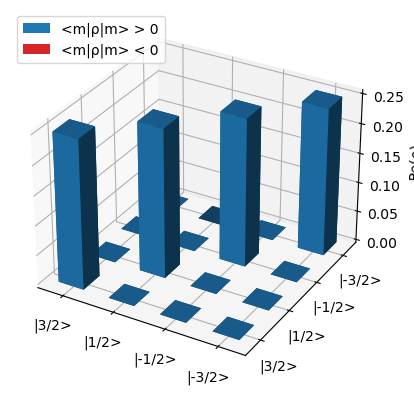

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

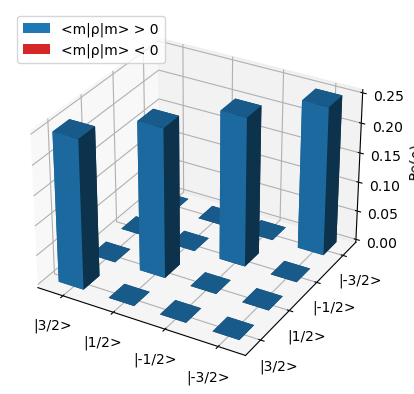

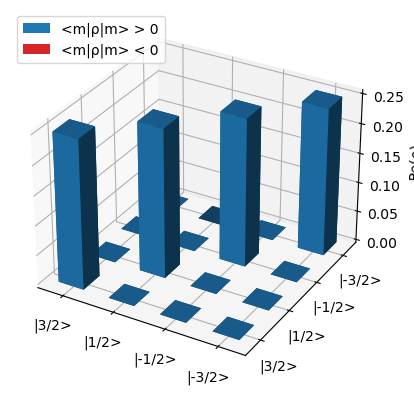

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

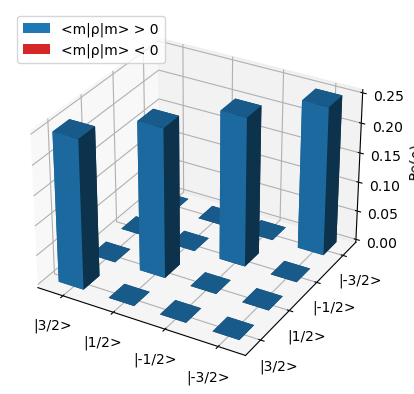

In [15]:
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : 0.,
				'gamma_q' : 0.,
				'order' : 0}

	spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-1)
	fig = plot_real_part_density_matrix(dm_initial)  
    
	t = np.linspace(0, 800, 5*800) # 50 second acquisition time, 1000 data points

	iz, ix, iy = (spin.I['z'], spin.I['x'], spin.I['y'])

	rot_dm = apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, par=True, T2=100)
	fig = plot_real_part_density_matrix(dm_evolved)
	FID = e_ops[0]

	f, ft = fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])


Plot exact diagonalization solution:

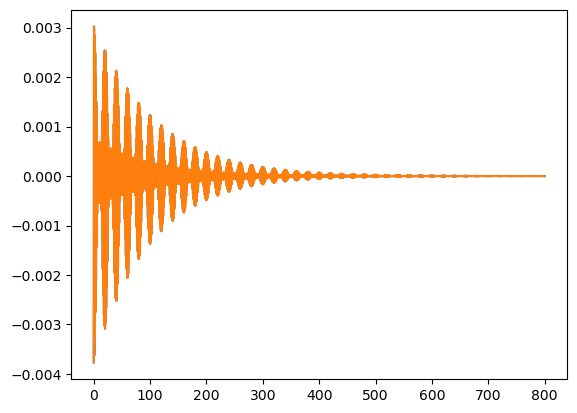

In [16]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_ed: 
	plt.plot(t, np.imag(fid))

Because of the idealized Ix pulse, exact diagonalization cannot exactly simulate experiments. 

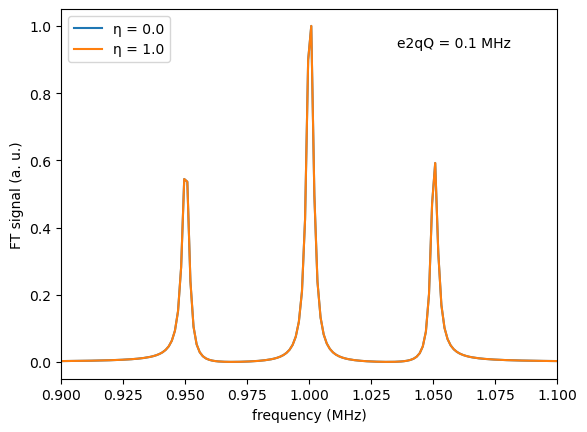

In [17]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_ed:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.9, 1.1)
plt.show()

Because of the instatenous pulse, we have an exact $\pi/2$ pulse and the peaks for the $\eta = 0$ case are symmetric around the central peak. 

Simulate with exact diagonalization approach \& 2 different stretched exponential decays:

In [18]:
etas = [0]
fts_ed = [] 

for eta in etas:
	quad_par = {'coupling constant' : e2qQ,
				'asymmetry parameter' : eta,
				'alpha_q' : 0.,
				'beta_q' : 0.,
				'gamma_q' : 0.,
				'order' : 0}

	spin, h_unperturbed, dm_initial = nuclear_system_setup(spin_par, quad_par=quad_par, 
										zeem_par=zeem_par, initial_state='canonical', temperature=1e-1)

    
    
	t = np.linspace(0, 800, 5*800) # 50 second acquisition time, 1000 data points

	ix, iy, iz = qt.spin_J_set(3 / 2)
	rot_dm = apply_rot_pulse(dm_initial, np.pi/2, ix) # rotate about x axis
	dm_evolved, e_ops = ed_evolve(h_unperturbed, rot_dm, spin, t, e_ops=[], fid=True, par=True, T2=[lambda t: np.exp(-(t/100)**1.5), lambda t: np.exp(-(t/100)**2)])
    
	FID = e_ops[0]

	f, ft = fourier_transform_signal(FID, t, padding=0)
	fts_ed.append([eta, f, ft, t, FID])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

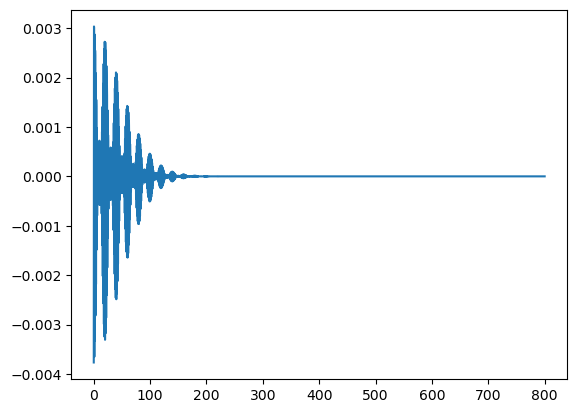

In [19]:
fig, ax = plt.subplots() 
for eta, f, ft, t, fid in fts_ed: 
	plt.plot(t, np.imag(fid))

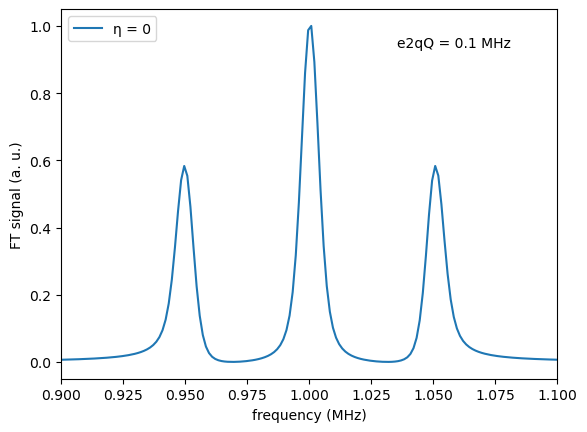

In [20]:
fig, ax = plt.subplots()
for eta, f, ft, t, fid in fts_ed:
    plt.plot(f, (np.absolute(ft)/np.max(np.absolute(ft)))**2, label="\N{GREEK SMALL LETTER ETA} = " + str(np.round(eta, 2)))

plt.figtext(.65, .8, 'e2qQ = ' + str(np.round(e2qQ, 3)) + ' MHz')
plt.legend(loc='upper left')
plt.xlabel("frequency (MHz)")    
plt.ylabel("FT signal (a. u.)")
plt.xlim(0.9, 1.1)
plt.show()

The peaks here are broadened by two stetched exponentials $\exp(-(t/T_2)^\beta)$, where $T_2 = 100 \ \mu$s and $\beta = \{1.5, 2\}$.